**Table of contents**<a id='toc0_'></a>    
1.1. [Load Data](#toc1_1_)    
1.2. [Data Visualization](#toc1_2_)    
1.3. [Assumptions Check](#toc1_3_)    
1.3.1. [Dependency check](#toc1_3_1_)    
1.3.2. [Normality & Homoscedasticity Assumptions Check](#toc1_3_2_)    
1.4. [Analyse of Variances](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg

## 1.1. <a id='toc1_1_'></a>[Load Data](#toc0_)

In [3]:
df = pd.read_excel("data/data.xlsx")
df.head()

,Date,LC2A,MP2,MP1,MC
0,22/10/2025 18:00,721.0,870.75,845.12,850.2
1,22/10/2025 20:00,650.0,760.20,848.10,889.8
2,22/10/2025 22:30,644.0,638.40,749.00,682.3
3,23/10/2025 01:00,636.0,552.70,741.00,658.2
4,23/10/2025 04:00,649.0,607.42,755.40,670.2


In [4]:
cols = ["Date", "LC2A", "MP2", "MP1", "MC"]

data = (df[cols]
    .melt(id_vars="Date", var_name="group", value_name="value")
    .dropna()
    .sort_values(by="Date")
    .drop(columns=["Date", "group"])
)
data.head(6)

,value
0,721.00
69,850.20
46,845.12
23,870.75
70,889.80
24,760.20


## Basic Summary Statistics

In [5]:
stats_summary:pd.DataFrame = data.describe()
# add skewness and kurtisis to stats_summary
stats_summary.loc["skewness"] = data.skew().values[0]
stats_summary.loc["kurtosis"] = data.kurtosis().values[0]
stats_summary.round(3).T

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
value,88.0,711.331,75.379,535.0,657.65,718.5,760.438,889.8,-0.102,-0.289


## 1.2. <a id='toc1_2_'></a>[Data Visualization](#toc0_)

In [6]:
X = data.values
n = 1_000
X = np.random.normal(0, 1, n)
X = X.flatten()

[]

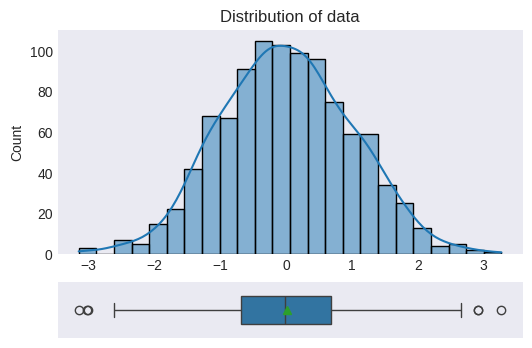

In [7]:
plt.style.use("seaborn-v0_8-dark")
fig, ax = plt.subplots(2, figsize=(6,4), height_ratios=(0.8,0.2))
sns.histplot(X, kde=True, bins='auto', ax=ax[0])
sns.boxplot(X, orient='h', ax=ax[1], width=0.5, showmeans=True)
ax[0].set_title("Distribution of data")
ax[1].set_xticks([])
# plt.tight_layout()

## 1.3. <a id='toc1_3_'></a>[Assumptions Check](#toc0_)

In [8]:
from assumptions import check_multimodality, check_normality, recommand_normality_test
from robustness import recommand_outliers_test

n = len(X)
method = recommand_normality_test(n, 8/n)['alias']
is_unimodal = check_multimodality(X)
is_normal = check_normality(X, method=method, return_stats=False)
recommand_outliers_test(n, is_normal, is_unimodal)
is_normal


======== GAUSSIAN MIXTURE MODEL (BIC COMPARISON) ========
--------------------------------------------------
Components      BIC                    AIC
--------------------------------------------------
1            2842.83 ← BEST         2833.01 ← BEST        
2            2865.98                2841.44               
3            2891.91                2852.65               
4            2915.55                2861.57               
5            2927.00                2858.30               
--------------------------------------------------
✓ Data appear UNIMODAL (1 component)



True

### 1.3.2. <a id='toc1_3_2_'></a>[Normality](#toc0_)

In [15]:
normality_result = pg.normality(data=X, method='shapiro')
is_all_normal = normality_result.all(bool_only=True).iat[0]
normality_result

,W,pval,normal
0,0.99799,0.278629,True
